In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import cv2

from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cpu")

In [51]:
def plot_norms(episodes):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $\pm \sigma$ interval')
    plt.xlabel('L2 Norm of Noise')
    plt.ylabel('Average Reward')
    
    for ep, color, label in episodes:
        x, ys = np.array(list(ep.keys())).astype(np.float), np.array(list(ep.values()))
        
        # normalise to the highest reward
        # y = np.mean(ep[0]) for normalising against the first data point
        #y = np.max([np.mean(ep[k]) for k in ep.keys()])
        #ys = (ys - y) / y
        
        mu = np.mean(ys, axis=1)
        plt.plot(x / 10, mu, label=label, color=color)
        stds = np.std(ys, axis = 1)
        #plt.fill_between(x / 10, mu + np.max(ys, axis=1) , mu - np.min(ys, axis=1), alpha=0.2, color=color)
        plt.fill_between(x / 10, mu + stds , mu - stds, alpha=0.2, color=color)
    
    plt.legend()
    
    plt.savefig('noise_sigma.pdf', format='pdf', dpi=1000)

In [2]:
def plot_norms_minmax(episodes):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $min/max$ interval')
    plt.xlabel('L2 Norm of Noise')
    plt.ylabel('Average Reward')
    
    for ep, color, label in episodes:
        x, ys = np.array(list(ep.keys())).astype(np.float), np.array(list(ep.values()))
        
        # normalise to the highest reward
        # y = np.mean(ep[0]) for normalising against the first data point
        #y = np.max([np.mean(ep[k]) for k in ep.keys()])
        #ys = (ys - y) / y
        
        mu = np.mean(ys, axis=1)
        plt.plot(x / 10, mu, label=label, color=color)
        stds = np.std(ys, axis = 1)
        plt.fill_between(x / 10, np.max(ys, axis=1) , np.min(ys, axis=1), alpha=0.2, color=color)
    
    plt.legend()
    
    plt.savefig('noise_minmax.pdf', format='pdf', dpi=1000)

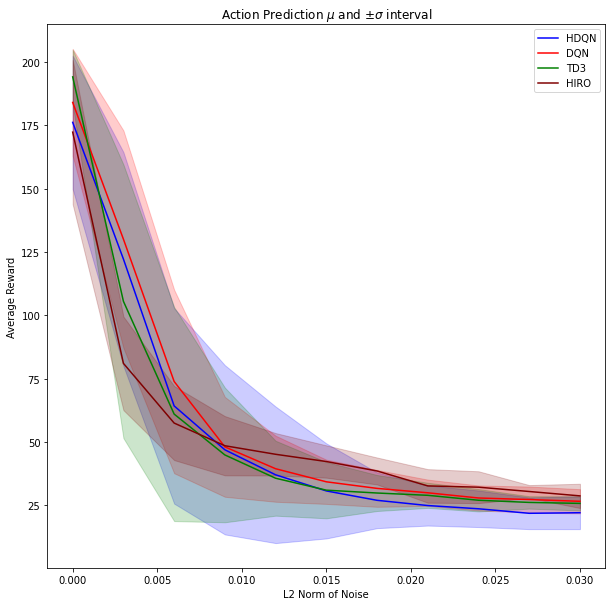

In [52]:
import json
plot_norms([\
    (json.load(open("absolute_noise/hdqn_episodes.json")), "blue", "HDQN"),\
    (json.load(open("absolute_noise/dqn_episodes.json")), "red", "DQN"),\
    (json.load(open("absolute_noise/td3_episodes.json")), "green", "TD3"),\
    (json.load(open("absolute_noise/hiro_episodes.json")), "maroon", "HIRO")])

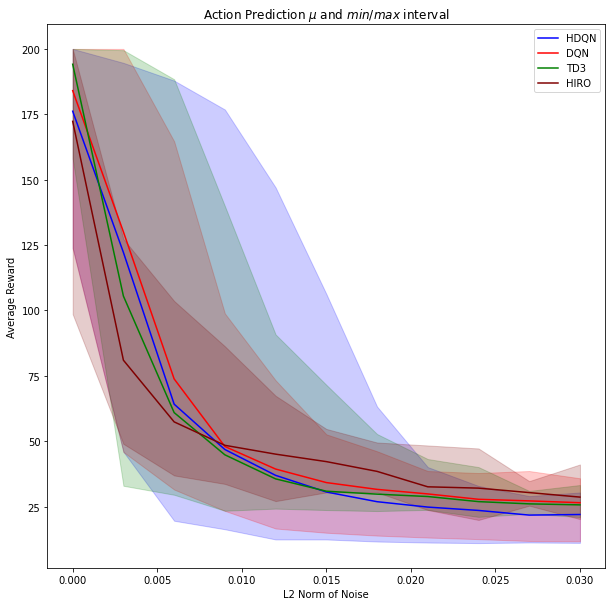

In [4]:
import json
plot_norms_minmax([\
    (json.load(open("absolute_noise/hdqn_episodes.json")), "blue", "HDQN"),\
    (json.load(open("absolute_noise/dqn_episodes.json")), "red", "DQN"),\
    (json.load(open("absolute_noise/td3_episodes.json")), "green", "TD3"),\
    (json.load(open("absolute_noise/hiro_episodes.json")), "maroon", "HIRO")])

In [45]:
hiro1 = {0.0: [143.77, 174.38, 53.54, 98.58, 176.31, 143.91, 167.55], 0.03: [95.86, 88.65, 77.14, 50.71, 69.51, 84.82, 85.03], 0.06: [58.17, 63.32, 57.04, 38.7, 47.22, 54.36, 50.89], 0.09: [61.33, 60.17, 32.51, 33.7, 35.42, 36.47, 44.91], 0.12: [50.89, 46.14, 36.82, 37.48, 45.84, 42.24, 38.76], 0.15: [41.34, 47.95, 29.95, 30.46, 31.23, 36.25, 37.73], 0.18: [38.15, 39.91, 29.22, 32.24, 30.5, 37.39, 31.98], 0.21: [39.82, 33.47, 22.92, 31.59, 27.03, 23.73, 27.78], 0.24: [36.34, 33.07, 26.14, 31.13, 31.55, 30.75, 30.44], 0.27: [30.53, 30.95, 25.95, 28.4, 30.65, 28.72, 27.64], 0.3: [30.75, 32.11, 22.85, 28.41, 24.72, 27.12, 26.18]}

In [46]:
hiro2 = {0.0: [196.11, 176.31, 180.8, 33.17, 193.73, 195.95, 185.17, 101.27, 183.08, 196.49, 171.98, 177.02, 188.87, 194.87, 200.0], 0.03: [107.56, 69.83, 87.76, 30.62, 49.01, 75.58, 73.05, 75.83, 76.47, 92.45, 87.78, 51.02, 76.78, 94.71, 127.3], 0.06: [48.14, 73.4, 66.62, 26.11, 56.57, 50.53, 48.25, 45.53, 61.78, 69.84, 36.94, 51.2, 72.37, 50.76, 103.62], 0.09: [48.25, 44.41, 55.95, 28.12, 39.76, 41.82, 49.77, 43.13, 53.69, 41.55, 40.55, 43.6, 55.69, 52.6, 86.32], 0.12: [51.96, 27.13, 38.82, 26.13, 34.11, 49.11, 51.4, 50.06, 48.95, 52.6, 47.36, 42.97, 38.06, 40.25, 67.39], 0.15: [39.52, 41.32, 44.53, 34.69, 33.44, 46.03, 47.38, 53.31, 42.55, 43.6, 49.09, 39.91, 42.13, 41.94, 54.71], 0.18: [43.41, 44.7, 36.1, 20.63, 30.99, 49.52, 42.93, 41.81, 35.01, 32.13, 44.03, 38.07, 34.72, 42.87, 43.26], 0.21: [39.57, 26.7, 35.2, 29.75, 28.8, 43.6, 33.16, 35.35, 32.17, 33.31, 24.75, 37.63, 25.59, 24.08, 48.39], 0.24: [39.34, 19.92, 29.84, 29.92, 27.38, 41.07, 39.9, 30.34, 33.68, 32.24, 21.09, 26.58, 30.0, 29.76, 47.25], 0.27: [33.67, 29.5, 27.93, 24.95, 28.24, 33.68, 29.71, 33.06, 32.81, 32.69, 32.82, 25.38, 29.34, 27.09, 34.76], 0.3: [36.98, 34.13, 28.43, 24.77, 27.9, 26.26, 22.69, 29.82, 28.59, 25.95, 32.08, 25.2, 24.37, 20.25, 41.13]}

In [47]:
for i in hiro1.keys():
    hiro1[i].pop(2)
    hiro2[i].pop(3)
hiro = {}
for i in hiro1.keys():
    all_i = list(np.clip(np.concatenate([hiro1[i], hiro2[i]]), 0, 500))
    hiro[i] = all_i

In [48]:
import json
json = json.dumps(hiro)
f = open("hiro_episodes.json","w")
f.write(json)
f.close()

In [19]:
td3 = {0.0: [199.96, 195.21, 200.0, 199.13, 200.0, 200.0, 200.0, 189.13, 197.08, 199.88, 194.55], 0.03: [114.3, 36.53, 109.54, 181.7, 103.88, 32.98, 125.95, 49.81, 156.45, 39.77, 154.84], 0.06: [44.66, 35.35, 46.66, 92.69, 40.73, 29.54, 60.17, 34.51, 64.16, 33.38, 54.87], 0.09: [32.73, 29.24, 41.25, 51.72, 32.98, 23.44, 47.9, 25.82, 41.79, 30.17, 39.23], 0.12: [31.22, 24.25, 30.37, 35.86, 28.04, 26.34, 43.63, 29.31, 34.03, 26.86, 35.54], 0.15: [26.47, 26.01, 26.39, 30.36, 27.17, 23.71, 35.43, 23.95, 27.73, 26.45, 31.1], 0.18: [26.0, 26.29, 26.05, 34.3, 27.74, 23.32, 34.1, 26.82, 29.81, 25.18, 28.53], 0.21: [27.36, 23.77, 24.93, 28.95, 26.71, 24.65, 33.64, 28.84, 30.56, 26.3, 28.86], 0.24: [23.73, 23.08, 27.99, 27.3, 28.05, 21.1, 29.75, 24.36, 28.08, 25.18, 27.69], 0.27: [24.16, 22.83, 25.06, 27.53, 25.95, 23.67, 27.68, 23.45, 28.17, 25.66, 25.87], 0.3: [22.96, 23.65, 26.95, 25.28, 27.42, 26.27, 28.25, 21.02, 25.08, 23.58, 23.48]}


In [20]:
import json
json = json.dumps(td3)
f = open("td3_episodes.json","w")
f.write(json)
f.close()